数据加载

In [1]:
import pickle
from pyspark.sql import SparkSession

# 初始化 SparkSession
spark = SparkSession.builder.appName("DCNModel").config(
    "spark.driver.memory", "8g").getOrCreate()

# 加载数据集
train_df = spark.read.parquet("./data/train_set.parquet")
val_df = spark.read.parquet("./data/val_set.parquet")

# 加载字典
with open('./data/val_rectop500_CrossEntropyLoss.pickle', 'rb') as f1:
    val_rec500 = pickle.load(f1)

with open('./data/user_FeatureVector_dict.pickle', 'rb') as f2:
    user_FeatureVector_dict = pickle.load(f2)

with open('./data/movie_FeatureVector_dict.pickle', 'rb') as f3:
    movie_FeatureVector_dict = pickle.load(f3)

24/09/01 01:28:11 WARN Utils: Your hostname, yvjie-Lenovo-Legion-Y7000-2019-1050 resolves to a loopback address: 127.0.1.1; using 172.24.70.50 instead (on interface wlp0s20f3)
24/09/01 01:28:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/09/01 01:28:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import FloatType

def rating_segment(avg_rating):
    if avg_rating == 1:
        return 0.2
    elif avg_rating == 2:
        return 0.4
    elif avg_rating == 3:
        return 0.6
    elif avg_rating == 4:
        return 0.8
    elif avg_rating == 5:
        return 1.0
    
segmented_rating_udf = udf(rating_segment, returnType=FloatType())
train_df = train_df.withColumn("weight", segmented_rating_udf(col('rating')).cast(FloatType()))
val_df = val_df.withColumn('weight', lit(1.0))

In [3]:
import random

train_list = train_df.rdd.map(lambda row: [row['user_id'], row['movie_id'], row['label'], row['weight']]).collect()
val_list = val_df.rdd.map(lambda row: [row['user_id'], row['movie_id'], row['label'], row['weight']]).collect()
random.shuffle(train_list)
random.shuffle(val_list)

加载数据并生成data_loader

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(dataset_list, user_FeatureVector_dict, movie_FeatureVector_dict):
    user_features = []
    movie_features = []
    labels = []
    weights = []

    for sample in dataset_list:
        user_feature = user_FeatureVector_dict[sample[0]]
        movie_feature = movie_FeatureVector_dict[sample[1]]
        label = sample[2]
        weight = sample[3]
        user_features.append(user_feature)
        movie_features.append(movie_feature)
        labels.append(label)
        weights.append(weight)
    # 转换为Tensor
    user_features_tensor = torch.tensor(user_features).to(dtype=torch.float32)
    movie_features_tensor = torch.tensor(movie_features).to(dtype=torch.float32)
    labelss_tensor = torch.tensor(labels).to(dtype=torch.float32)
    weights_tensor = torch.tensor(weights).to(dtype=torch.float32)
    # 创建TensorDataset
    dataset = TensorDataset(user_features_tensor, movie_features_tensor, labelss_tensor, weights_tensor)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    return data_loader

train_loader = create_dataloader(train_list, user_FeatureVector_dict, movie_FeatureVector_dict)
val_loader = create_dataloader(val_list, user_FeatureVector_dict, movie_FeatureVector_dict)


下面是之前加载数据的代码，不执行

In [ ]:
# import torch
# import os

# def save_large_data_to_multiple_files(rdd, batch_size, output_dir, base_filename):
#     rdd = rdd.zipWithIndex().cache()
#     num_rows = rdd.count()
#     num_batches = (num_rows + batch_size - 1) // batch_size

#     # 创建保存文件的目录
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # 分批保存数据
#     for i in range(num_batches):
#         start = i * batch_size
#         end = min(start + batch_size, num_rows)

#         data_batch = rdd.filter(lambda x: start <= x[1] < end).map(lambda x: x[0]).collect()

#         user_features_batch = []
#         movie_features_batch = []
#         ratings_batch = []

#         for row in data_batch:
#             user_id = torch.tensor(row['user_id']).unsqueeze(0).unsqueeze(1)
#             gender = torch.tensor(row['gender']).unsqueeze(0).unsqueeze(1)
#             age_vector = torch.tensor(row['ageVector']).unsqueeze(0)
#             occupation_vector = torch.tensor(row['occupationVector']).unsqueeze(0)
#             user_avg_rating_vector = torch.tensor(row['user_avg_ratingVector']).unsqueeze(0)
#             movie_id = torch.tensor(row['movie_id']).unsqueeze(0).unsqueeze(1)
#             genres_vector = torch.tensor(row['genresVector']).unsqueeze(0)
#             movie_avg_rating_vector = torch.tensor(row['movie_avg_ratingVector']).unsqueeze(0)
#             rating = torch.tensor(row['rating']).unsqueeze(0)

#             user_features = torch.cat([user_id, gender, age_vector, occupation_vector, user_avg_rating_vector], dim=1)
#             movie_features = torch.cat([movie_id, genres_vector, movie_avg_rating_vector], dim=1)

#             user_features_batch.append(user_features)
#             movie_features_batch.append(movie_features)
#             ratings_batch.append(rating)

#         user_features_batch = torch.stack(user_features_batch)
#         movie_features_batch = torch.stack(movie_features_batch)
#         ratings_batch = torch.stack(ratings_batch)

#         # 保存到 .pt 文件
#         filename = f"{base_filename}_batch_{i+1}.pt"
#         filepath = os.path.join(output_dir, filename)
#         torch.save((user_features_batch, movie_features_batch, ratings_batch), filepath)
#         print(f"Saved batch {i+1}/{num_batches} to {filepath}")

# # 将 DataFrame 转换为 RDD
# train_rdd = train_df.rdd
# val_rdd = val_df.rdd

# # 参数设置
# output_dir = './dcn_data'
# batch_size = 100000
# base_filename = 'train_data'

# # 分批保存 train_rdd
# save_large_data_to_multiple_files(train_rdd, batch_size, output_dir, base_filename)
# base_filename = 'val_data'
# save_large_data_to_multiple_files(val_rdd, batch_size, output_dir, base_filename)

In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import os

# def load_data(output_dir, base_filename, num_batches):
#     all_data = []
#     for i in range(num_batches):
#         filepath = os.path.join(output_dir, f"{base_filename}_batch_{i+1}.pt")
#         data = torch.load(filepath)
#         all_data.append(data)
    
#     # 将所有批次的数据堆叠起来
#     all_data = [torch.cat(tensors, dim=0) for tensors in zip(*all_data)]
#     dataset = TensorDataset(*all_data)
#     return dataset

# def get_data_loader(dataset, batch_size=64, shuffle=True):
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# train_num_batches = 9
# val_num_batches = 1
# # 加载数据
# train_dataset = load_data('./dcn_data', 'train_data', num_batches=train_num_batches)
# val_dataset = load_data('./dcn_data', 'val_data', num_batches=val_num_batches)

# # 获取DataLoader
# train_loader = get_data_loader(train_dataset, batch_size=64, shuffle=True)
# val_loader = get_data_loader(val_dataset, batch_size=64, shuffle=True)  # 验证集通常不需要打乱


构建、训练模型

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init


class FeatureEmbedder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(FeatureEmbedder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.normal_(self.embedding.weight, mean=0.0, std=0.01)  # 正态分布初始化

    def forward(self, x):
        return self.embedding(x)

# DCN模型
class DCN(nn.Module):
    def __init__(self, user_num, movie_num, user_feature_dim, movie_feature_dim, embedding_dim, embed_dim,  hidden_dim,
                    cross_layers=3, num_classes=1):
        super(DCN, self).__init__()
        self.user_embed = FeatureEmbedder(user_num, embedding_dim)
        self.movie_embed = FeatureEmbedder(movie_num, embedding_dim)
        self.user_fc = nn.Sequential(
            nn.Linear(embedding_dim + user_feature_dim, embed_dim), 
        )
        self.movie_embed = FeatureEmbedder(movie_num, embedding_dim)
        self.movie_fc = nn.Sequential(
            nn.Linear(embedding_dim + movie_feature_dim, embed_dim),
        )
        self.input_dim = embed_dim + embed_dim

        # Cross Network
        self.cross_layers = cross_layers
        self.cross_w = nn.ParameterList(
            [nn.Parameter(torch.randn(self.input_dim)) for _ in range(cross_layers)])
        self.cross_b = nn.ParameterList(
            [nn.Parameter(torch.randn(self.input_dim)) for _ in range(cross_layers)])

        # Deep Network
        self.deep = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  
            nn.ReLU()
        )

        # Final Layer
        self.output_layer = nn.Linear(hidden_dim + self.input_dim, num_classes)

    def forward(self, user_features, movie_features):
        user_embedded = self.get_user_embedding(user_features)
        movie_embedded = self.get_movie_embedding(movie_features)
        
        x0 = torch.cat([user_embedded, movie_embedded], dim=1)
        x0= F.normalize(x0, p=2, dim=1)
        x = x0

        # Deep Network
        deep_out = self.deep(x)

        # Cross Network
        for i in range(self.cross_layers):
            xw = torch.sum(x * self.cross_w[i], dim=1, keepdim=True)
            x = x0 * xw + self.cross_b[i] + x

        # Concatenate Cross Network and Deep Network
        concat_out = torch.cat((x, deep_out), dim=1)

        # Output Layer
        out = self.output_layer(concat_out)
        prob = F.sigmoid(out)
        return prob

    def get_user_embedding(self, user_features):
        # 用户塔的嵌入
        user_embedded = torch.cat([
            self.user_embed(user_features[:, 0].int()),
            user_features[:, 1:]
        ], dim=1).to(dtype=torch.float32)
        # 用户塔的全连接层
        user_output = self.user_fc(user_embedded)
        # 对输出向量进行 L2 归一化
        return user_output

    def get_movie_embedding(self, movie_features):
        # 物品塔的嵌入
        movie_embedded = torch.cat([
            self.movie_embed(movie_features[:, 0].int()),
            movie_features[:, 1:]
        ], dim=1).to(dtype=torch.float32)
        # 物品塔的全连接层
        movie_output = self.movie_fc(movie_embedded)

        return movie_output

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()

user_num = 6041
movie_num = 3707
age_categories = 7
occupation_categories = 21
user_avg_rating_categories = 8
genres_categories = 18
movie_avg_rating_categories = 8
user_feature_dim = age_categories + occupation_categories + user_avg_rating_categories + 1
movie_feature_dim = genres_categories + movie_avg_rating_categories
embedding_dim = 128
embed_dim = 64
hidden_dim = 128


ranking_model = DCN(user_num, movie_num, user_feature_dim, movie_feature_dim, embedding_dim, embed_dim, hidden_dim, cross_layers=3)

training model

In [ ]:
# # 自定义RMSE损失函数
# def rmse(predictions, targets):
#     return torch.sqrt(nn.MSELoss()(predictions, targets))

# # R2 Score
# def r2_score(predictions, targets):
#     mean_targets = torch.mean(targets)
#     ss_res = torch.sum((targets - predictions) ** 2)
#     ss_tot = torch.sum((targets - mean_targets) ** 2)
#     r2 = 1 - ss_res / ss_tot
#     return r2

# # MAE
# def mae(predictions, targets):
#     return torch.mean(torch.abs(predictions - targets))

# # MAPE
# def mape(predictions, targets):
#     # To prevent division by zero
#     mask = targets != 0
#     return torch.mean(torch.abs((predictions - targets) / targets) * mask) * 100

# # 评估指标计算
# def compute_metrics(predictions, targets):
#     rmse_value = rmse(predictions, targets)
#     r2_value = r2_score(predictions, targets)
#     mae_value = mae(predictions, targets)
#     mape_value = mape(predictions, targets)
#     return rmse_value, r2_value, mae_value, mape_value

Epoch 1/5


Training Progress: 100%|██████████| 36807/36807 [03:53<00:00, 157.36it/s]


Evaluating on Train Set:


Evaluation Progress: 100%|██████████| 36807/36807 [01:11<00:00, 514.98it/s]


Epoch Loss: 0.6701
Best F1 score: 0.5442
Best threshold: 0.0000


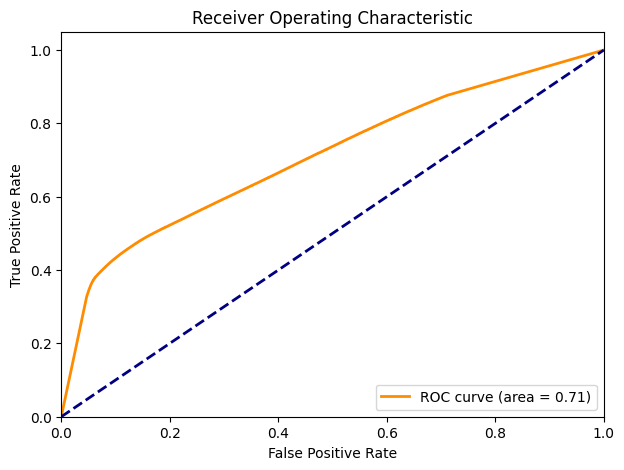

Evaluating on Val Set:


Evaluation Progress: 100%|██████████| 1194/1194 [00:02<00:00, 521.78it/s]


Epoch Loss: 0.6748
Best F1 score: 0.5385
Best threshold: 0.0000


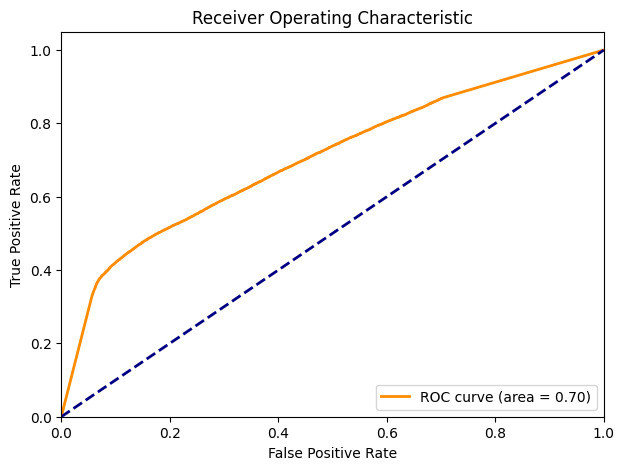

Epoch 2/5


Training Progress: 100%|██████████| 36807/36807 [04:33<00:00, 134.49it/s]


Evaluating on Train Set:


Evaluation Progress: 100%|██████████| 36807/36807 [02:11<00:00, 280.46it/s] 


Epoch Loss: 0.6700
Best F1 score: 0.5319
Best threshold: 0.0000


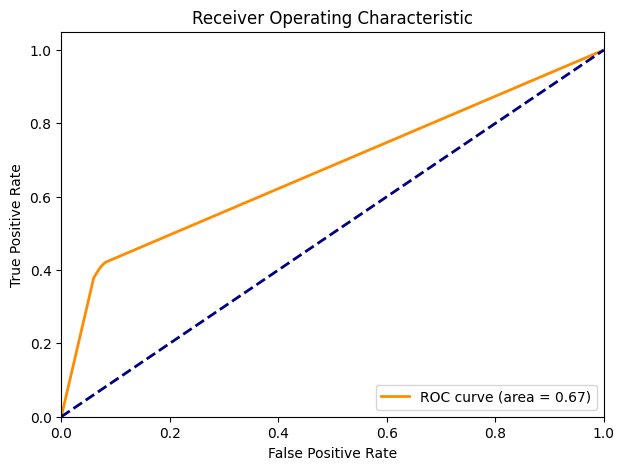

Evaluating on Val Set:


Evaluation Progress: 100%|██████████| 1194/1194 [00:02<00:00, 415.77it/s]


Epoch Loss: 0.6750
Best F1 score: 0.5225
Best threshold: 0.0000


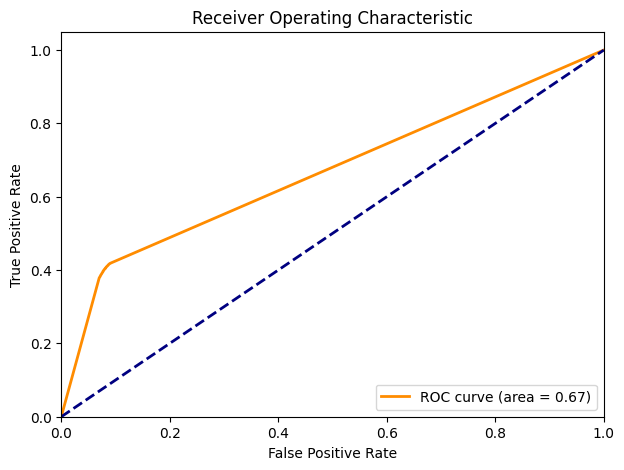

Epoch 3/5


Training Progress:  13%|█▎        | 4664/36807 [00:31<03:33, 150.31it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ranking_model.to(device)
# 使用混合精度训练
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(ranking_model.parameters())

def evaluate_model(model, data_loader):
    all_probs = []
    all_labels = []
    batch_num = 0
    epoch_loss = 0
    
    with torch.no_grad():
        for user_features, movie_features, labels in tqdm(data_loader, desc='Evaluation Progress'):
            user_features = user_features.to(device, non_blocking=True)
            movie_features = movie_features.to(device, non_blocking=True)
            labels = labels.unsqueeze(1).to(device, non_blocking=True)
            
            probs = model(user_features, movie_features)
            batch_loss = criterion(probs, labels)
            epoch_loss += batch_loss.item()
            batch_num += 1
            
            # 收集所有预测概率和真实标签
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    loss = epoch_loss/batch_num
    print(f'Epoch Loss: {loss:.4f}')
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve for F1
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_threshold = thresholds[best_idx]
    print(f'Best F1 score: {best_f1:.4f}')
    print(f'Best threshold: {best_threshold:.4f}')

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return loss


def train_model(model, train_loader, num_epochs=10):
    model.train()
    epoch_list = [i+1 for i in range(num_epochs)]
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for user_features, movie_features, labels in tqdm(train_loader, desc='Training Progress'):
            user_features = user_features.to(device, non_blocking=True)
            movie_features = movie_features.to(device, non_blocking=True)
            labels = labels.unsqueeze(1).to(device, non_blocking=True)
            optimizer.zero_grad()
            # 在训练循环中使用混合精度
            with torch.cuda.amp.autocast():
                probs = model(user_features, movie_features)
                loss = criterion(probs, labels)
            # 反向传播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        # 计算训练集的损失
        print("Evaluating on Train Set:")
        train_loss = evaluate_model(model, train_loader)
        train_losses.append(train_loss)
        # 计算训练集的损失
        print("Evaluating on Val Set:")
        val_loss = evaluate_model(model, val_loader)
        val_losses.append(val_loss)


    # 创建一个图形和两个子图，用于显示训练损失和验证损失
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 在第一个子图中绘制训练损失
    ax1.plot(epoch_list, train_losses, label='Train Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 在第二个子图中绘制验证损失
    ax2.plot(epoch_list, val_losses, label='Val Loss')
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()


# 训练模型
num_epochs = 5
train_model(ranking_model, train_loader, num_epochs)

In [ ]:
# 假设 recall_model 是您已经训练好的模型
PATH = './rank_model/DCNModel_CrossEntropyLoss.pth'

# 保存整个模型
torch.save(ranking_model, PATH)

In [ ]:
# 假设 recall_model 是您已经训练好的模型
PATH = './rank_model/DCNModel_CrossEntropyLoss.pth'

# 加载整个模型
ranking_model = torch.load(PATH)

In [ ]:
from tqdm import tqdm

def get_rank_movies(rec_dict, rank_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 尝试使用GPU
    rank_model.to(device)
    rank_model.eval()
    user_rec_movie_dict = {}
    for user, rec_movies in tqdm(rec_dict.items()):
        movie_features = []
        movie_prob_list = []
        user_feature = user_FeatureVector_dict[user]
        movie_list = [movie[0] for movie in rec_movies]
        for movie in movie_list:
            movie_feature = movie_FeatureVector_dict[movie]
            movie_features.append(movie_feature)
        user_features_tensor = torch.tensor(user_feature).expand(len(movie_list), len(user_feature)).to(dtype=torch.float32).to(device)
        movie_features_tensor = torch.tensor(movie_features).to(dtype=torch.float32).to(device)
        with torch.no_grad():
            probs = rank_model(user_features_tensor, movie_features_tensor)
        for i in range(len(probs)):
            movie_prob_list.append((movie_list[i], probs[i].item()))
        movie_prob_list = sorted(movie_prob_list, key=lambda x: x[1], reverse=True)
        user_rec_movie_dict[user] = movie_prob_list
    return user_rec_movie_dict

# 假设 user_FeatureVector_dict 和 movie_FeatureVector_dict 已经定义
user_rec_movie_dict = get_rank_movies(val_rec500, ranking_model)


100%|██████████| 6040/6040 [06:50<00:00, 14.72it/s]


In [ ]:
K=10
val_topK_rec = {}
val_rec500 = dict(sorted(val_rec500.items(), key=lambda item: item[1][1]))
for user, rec_movies in tqdm(val_rec500.items()):
    val_topK_rec[user] = [movie[0] for movie in rec_movies[:K]]

100%|██████████| 6040/6040 [00:00<00:00, 207292.21it/s]


In [ ]:
val_user_movies_dict = {}
for sample in tqdm(val_list):
    user_id = sample[0]
    movie_id = sample[1]
    label = sample[2]
    if user_id not in val_user_movies_dict:
        val_user_movies_dict[user_id] = []
    if label == 1:
        val_user_movies_dict[user_id].append(movie_id)

100%|██████████| 76389/76389 [00:00<00:00, 444001.64it/s]


In [ ]:
def recall(val_user_movies_dict, val_topK_rec):
    total_recall = 0
    total_user_movies = 0

    for user, true_movies in val_user_movies_dict.items():
        # 确保用户在user_movie_rating_dict中也有数据
        if user in val_topK_rec:
            rec_movies = val_topK_rec[user]
            # 计算模型预测正确的电影数量
            correct_movie = len(set(true_movies) & set(rec_movies))
            # 更新总召回数
            total_recall += correct_movie
            # 更新用户喜欢的电影总数
            total_user_movies += len(true_movies)

    # 计算召回率
    recall_score = total_recall / total_user_movies if total_user_movies > 0 else 0
    return recall_score

# 计算召回率
recall_score = recall(val_user_movies_dict, val_topK_rec)
print(f"Recall@10: {recall_score}")


Recall@10: 0.04357843721447583


In [ ]:
# 保存字典到文件
with open('./data/rectop10.pickle', 'wb') as f:
    pickle.dump(u, f)